# CNN, Image Augmentation
- 이진분류 문제 (cat, dog를 분류하는 모델)  
Cats vs Dogs로 다음처럼 모델링하고, 학습시키기  
4 convolutional layers with 32, 64, 128 and 128 convolutions  
train for 100 epochs
- 실 세계의 이미지 데이터는 어떻게 생성했나?
- 현업에서는 데이터가 스토리지 서비스에 저장
- 저장된 데이터에 이미지를 레이블링 해야 함

## 데이터 준비

In [1]:
import os, zipfile, pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# 윈도우 환경
import os
import zipfile
import urllib.request

In [3]:
# 압축을 풀 위치
extract_root = pathlib.Path("./datas_dnn")

- pip install gdown

In [4]:
import gdown  
# 데이터의 위치
url = "https://drive.google.com/uc?id=1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6"
file_id = "1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6"
output = "datas_dnn/cats_and_dogs_filtered.zip" # 저장 위치 및 저장할 파일 이름
zip_path = gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6
From (redirected): https://drive.google.com/uc?id=1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6&confirm=t&uuid=16754c2a-57bb-404c-a22c-4105282ef0f4
To: G:\내 드라이브\01_kpmg_7th\01_lab\tf_dnn_ex\datas_dnn\cats_and_dogs_filtered.zip
100%|█████████████████████████████████████████████████████████████████████████████| 69.4M/69.4M [00:04<00:00, 14.6MB/s]


## 압축 풀기

In [6]:
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_root)

- 현실 데이터는 이미지 사이즈가 제각각임
- 폴더명이 레이블 이름
## 학습, 검증 데이터 준비

In [7]:
# 이미지 사이즈
IMG_SIZE=150
IMAGE_SHAPE=(IMG_SIZE, IMG_SIZE, 3)

In [10]:
# 학습을 할때  단위, batch size
BATCH_SIZE = 20

In [11]:
# 재현을 위한 값
SEED = 1337

In [12]:
BASE_DIR = extract_root / 'cats_and_dogs_filtered'
train_dir  = BASE_DIR / 'train'
test_dir = BASE_DIR / 'validation'

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory
train_ds = image_dataset_from_directory(
    train_dir,            # 학습 데이터 위치
    image_size = (IMG_SIZE, IMG_SIZE), # 이미지 사이즈
    batch_size = BATCH_SIZE,           # batch 크기
    shuffle=True,                      # shuffle
    seed=SEED
)

Found 2001 files belonging to 2 classes.


In [15]:
test_ds = image_dataset_from_directory(
    test_dir,            # 학습 데이터 위치
    image_size = (IMG_SIZE, IMG_SIZE), # 이미지 사이즈
    batch_size = BATCH_SIZE,           # batch 크기
    shuffle=True                       # shuffle
)

Found 1003 files belonging to 2 classes.


In [16]:
# target(label)값 가져오기
train_ds.class_names

['cats', 'dogs']

In [17]:
test_ds.class_names

['cats', 'dogs']

## 성능 최적화를 위한 코드 (GPU 사용시)
- 다음 배치를 백그라운드에서 미리 준비하라는 코드 작성
- 학습 효과를 높이기 위해
- 데이터 증강, 데이터 플립

In [19]:
# TensorFlow가 prefetch 버퍼 크기를 자동으로 조절해주는 옵션
AUTOTUNE = tf.data.AUTOTUNE

# 학습 중 다음 배치(batch)를 백그라운드에서 미리 준비(학습 속도 빨라짐)
train_ds = train_ds.prefetch(AUTOTUNE)

# 검증(validation) 데이터도 동일하게 최적화하는 과정
test_ds = test_ds.prefetch(AUTOTUNE)

## 데이터 증강

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1)
    ],
    name = 'data_autmentation'
)

## 학습 모델 만들기
### 모델 설계

In [21]:
from tensorflow import keras
from tensorflow.keras import layers, Sequential

In [24]:
def build_model(input_shape):
    return Sequential(
        [
            layers.Input(shape=input_shape),
            data_augmentation,  # 데이터 증강
            layers.Rescaling(1.0/255.0),  # 스케일링
            layers.Conv2D(32, 3, activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(64, 3, activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(128, 3, activation='relu'),
            layers.MaxPooling2D(2, 2),

            # 출력층 전에 1차원으로 변경해야 함
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(2, activation='softmax')   # 출력층 2개
        ],
        name='simple_cnn',
    )

In [25]:
model = build_model(IMAGE_SHAPE)

In [26]:
model.summary()

Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_autmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,690 (72.61 MB)

 Trainable params: 19,034,690 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [31]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## 모델학습

In [32]:
history = model.fit(
    train_ds, validation_data = test_ds,
    epochs = 100,
    callbacks=[early_stop]
)

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 379ms/step - accuracy: 0.5162 - loss: 0.7429 - val_accuracy: 0.5723 - val_loss: 0.6896
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.5567 - loss: 0.6904 - val_accuracy: 0.5872 - val_loss: 0.6687
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 378ms/step - accuracy: 0.5942 - loss: 0.6748 - val_accuracy: 0.5982 - val_loss: 0.6625
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.6087 - loss: 0.6615 - val_accuracy: 0.6142 - val_loss: 0.6706
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.5757 - loss: 0.6741 - val_accuracy: 0.5773 - val_loss: 0.6750
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 378ms/step - accuracy: 0.6157 - loss: 0.6530 - val_accuracy: 0.6331 - val_loss: 0.6254
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 377ms/step - accuracy: 0.6302 - loss: 0.6454 - val_accuracy: 0.6391 - val_loss: 0.6367
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.6242 -

## 모델 평가

In [33]:
model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7079 - loss: 0.5678


[0.5678346753120422, 0.7078763842582703]

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

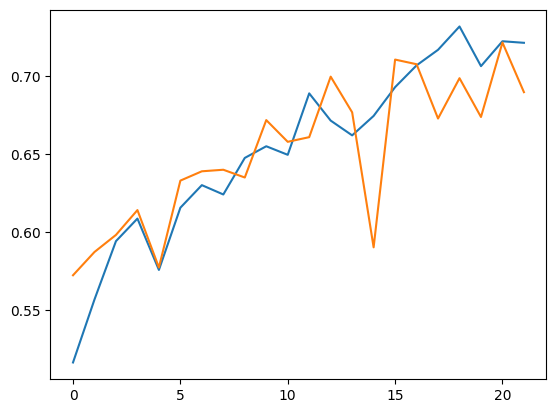

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

## 모델 저장하기

In [36]:
import os
os.makedirs('models', exist_ok=True)
model.save('models/my_dog_cat_model.keras')

## 일반화

In [39]:
import tensorflow as tf
import numpy as np

IMG_SIZE=150

def load_and_preprocess_image(img_path):
    img=tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array=tf.keras.utils.img_to_array(img)
    img_array=img_array/255.0
    img_array=np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(model, img_path, class_names):
    img=load_and_preprocess_image(img_path)
    pred=model.predict(img)
    print(pred)
    # 클래스 index
    pred_idx=np.argmax(pred, axis=1)[0]
    print(pred_idx)
    pred_class=class_names[pred_idx]
    pred_prob=np.max(pred)

    print(f'예측 클래스:{pred_class}')
    print(f'확률: {pred_prob:.4f}')

In [40]:
# 학습한 모델 불러오기
model = tf.keras.models.load_model("models/my_dog_cat_model.keras")

# 클래스 이름
class_names = ["cat", "dog"]

# 예측하고 싶은 이미지 경로
img_path = "datas_dnn/cat.jpg"

predict_image(model, img_path, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[0.9759513  0.02404865]]
0
예측 클래스:cat
확률: 0.9760


[[158 158 156]
 [158 158 156]
 [158 158 156]
 ...
 [151 149 150]
 [147 145 146]
 [167 165 166]]


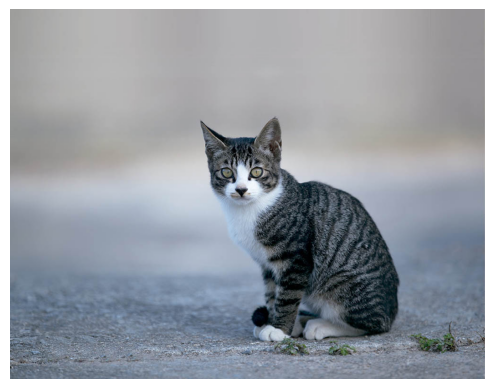

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 예측하고 싶은 이미지 경로
img_path = "datas_dnn/cat.jpg"

img = mpimg.imread(img_path)
print(img[0])
plt.imshow(img)
plt.axis('off')   # 축 제거 (선택)
plt.show()